In [2]:
from tracemalloc import start
import csv
from collections import defaultdict
from utils import load_stop_times_df
from tqdm import tqdm
import networkx as n
import json
import pandas as pd
from utils import load_stops
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage import gaussian_filter
import math as m
import matplotlib as mpl
from matplotlib import cm
from sklearn.preprocessing import minmax_scale
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

In [3]:
# load stops
df = load_stop_times_df("GER_Saxony_Leipzig")

# convert into timeformat
df["arrival_time"] = pd.to_datetime(df.arrival_time, errors = "coerce", format = "%H:%M:%S")
df["departure_time"] = pd.to_datetime(df.departure_time, errors = "coerce", format = "%H:%M:%S")

# shift some rows around so comparing a row with the one after it becomes easier
df["shift_up"] = df["trip_id"].shift(-1)
df["shifted_up_stop_id"] = df["stop_id"].shift(-1)
df["shifted_up_departure_time"] = df["departure_time"].shift(-1)

# set the column "neighbour" to NaN incase the line after has a new trip_id eq. is not a neighbour of the 
df.loc[df["trip_id"] == df["shift_up"], "neighbour"] = df["shifted_up_stop_id"]

# calculate trip time as timedelta, ignore any rows that have been flagged as "NaN" earlier
df.loc[df["neighbour"].isnull() == False, "timedelta"] = df["shifted_up_departure_time"] - df["arrival_time"]

g = n.Graph()

neighbour_list = df["neighbour"].tolist()
stop_id_list = df["stop_id"].tolist()
timedelta_list = df["timedelta"].tolist()


for neighbour, stop_id_list, timedelta in zip(neighbour_list, stop_id_list, timedelta_list):

    # check for "NaT" type, also convert "timedelta" type to seconds
    if type(timedelta) != pd._libs.tslibs.nattype.NaTType:
        g.add_edge(int(stop_id_list), int(neighbour), weight = int(timedelta.total_seconds()), n_id = int(stop_id_list))




In [4]:
# load coordinates as df (stop_id, lat, lon)
df_coordinates = load_stops("GER_Saxony_Leipzig")
df_coordinates.head()

# join both together
joined_df = pd.DataFrame()
joined_df = df.join(df_coordinates.set_index('stop_id'), on='stop_id')

# select only relevant cols
only_coordinates_df = joined_df[["trip_id", "stop_lat", "stop_lon"]]

# convert datatypes to str, else join() in the lambda wont work
only_coordinates_df[["stop_lat", "stop_lon"]] = only_coordinates_df[["stop_lat", "stop_lon"]].astype("str")

# group df by trip_id and list all coordinates after
grouped_df = only_coordinates_df.groupby("trip_id").agg({'stop_lat': lambda x: ' '.join(x), 'stop_lon': lambda x: ' '.join(x)})

# convert to 2d list [all_lat, all_lon]
as_list = grouped_df.values.T.tolist()


C:\Users\Lauris\AppData\Local\Temp\ipykernel_25292\29207181.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_coordinates_df[["stop_lat", "stop_lon"]] = only_coordinates_df[["stop_lat", "stop_lon"]].astype("str")


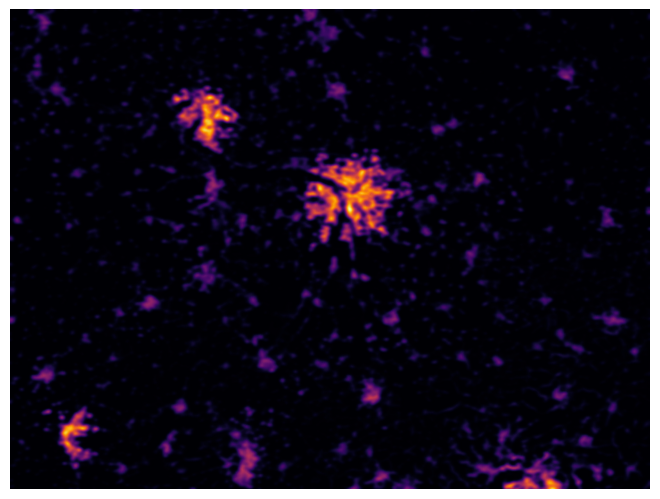

In [5]:
BINS = 1000

#  get minimum coordinates of dataframe
minlat = df_coordinates["stop_lat"].min()
maxlat = df_coordinates["stop_lat"].max()
minlon = df_coordinates["stop_lon"].min()
maxlon = df_coordinates["stop_lon"].max()

# get population data at square
pop_df = pd.read_csv("pop_ger.csv", sep = ",", names = ["lat","lon","weight"], skiprows = 1)

# select rows that are inside of the bounding box
pop_df = pop_df[(pop_df["lat"] >= minlat) & (pop_df["lat"] <= maxlat)]
pop_df = pop_df[(pop_df["lon"] >= minlon) & (pop_df["lon"] <= maxlon)]

# convert to numpy
lonlist = pop_df["lon"].to_list()
latlist = pop_df["lat"].to_list()
weight = pop_df["weight"].to_list

# plot
data = np.histogram2d(lonlist, latlist, weights = weight, bins=BINS)[0]
data = gaussian_filter(data, sigma=3)
plt.pcolormesh(data.T, cmap='inferno', shading='gouraud')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()



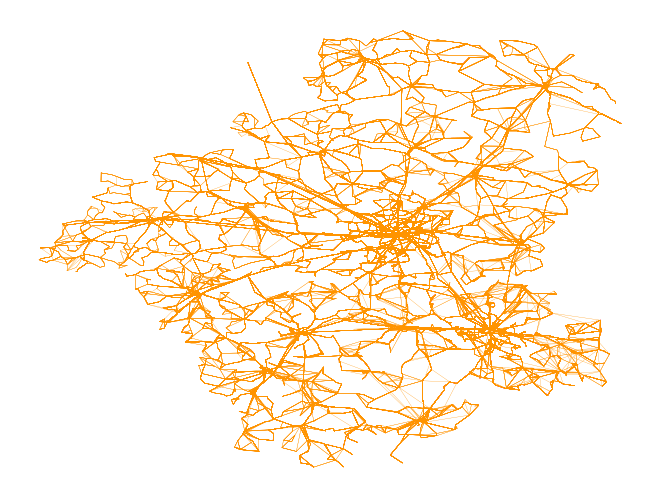

In [6]:
# convert linegraph data
for x, y in zip(as_list[0][0:], as_list[1][0:]):
    
    # seperate long x bzw y string into list
    x_list = x.split(" ")
    y_list = y.split(" ")

    x_list = list(map(float, x_list)) # convert to float
    y_list = list(map(float, y_list)) # convert to float


    plt.plot(x_list, y_list, linestyle = "-", c= "#ff9400", linewidth = "0.2")

plt.axis("off")
plt.tight_layout(pad=0)
plt.show()